# Euchre Trick Model
Model to estimate the number of tricks a given hand will be able to take  
(or maybe the percent likelihood of each number of tricks taken 0-5)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [154]:
# from autosklearn.regression import AutoSklearnRegressor

### Load in training data

In [4]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\euchre\\notebooks'

In [5]:
# TODO: move this from local to s3
raw_train_df = pd.read_csv('C:\\Users\\jerem\\Desktop\\nonsense\\euchre\\all_hand_results.csv')

In [6]:
raw_train_df.shape

(476716, 16)

In [7]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,partner_tricks,player_seat
0,2,1,0,1,0,0,0,0,1,1,0,1,0,2,1,4
1,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2,1
2,1,0,1,0,1,0,1,0,0,0,0,0,1,2,2,2
3,2,0,0,0,0,0,0,1,0,0,1,1,1,3,0,3
4,3,1,0,1,0,0,1,0,1,0,0,0,1,2,0,2


In [10]:
# raw_train_df['tricks_won'].hist(bins=11)

In [156]:
# raw_train_df['num_suits'].value_counts()

3    271763
4    133472
2     70773
1       708
Name: num_suits, dtype: int64

#### Features

In [12]:
# create team_tricks_won
raw_train_df['team_tricks_won'] = raw_train_df['partner_tricks'] + raw_train_df['tricks_won']

In [13]:
def make_player_seat_categorical(df):
    """
    Function to transform player seat field into categorical columns from given df
    """
    df['player_seat1'] = np.where(df['player_seat']==1,1,0)
    df['player_seat2'] = np.where(df['player_seat']==2,1,0)
    df['player_seat3'] = np.where(df['player_seat']==3,1,0)
    df['player_seat4'] = np.where(df['player_seat']==4,1,0)
    return df

In [14]:
raw_train_df = make_player_seat_categorical(raw_train_df)

In [15]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,...,num_off_K,num_off_Q,num_suits,partner_tricks,player_seat,team_tricks_won,player_seat1,player_seat2,player_seat3,player_seat4
0,2,1,0,1,0,0,0,0,1,1,...,1,0,2,1,4,3,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,1,2,1,0,0,0
2,1,0,1,0,1,0,1,0,0,0,...,0,1,2,2,2,3,0,1,0,0
3,2,0,0,0,0,0,0,1,0,0,...,1,1,3,0,3,2,0,0,1,0
4,3,1,0,1,0,0,1,0,1,0,...,0,1,2,0,2,3,0,1,0,0


### Create train/test/validation splits

In [200]:
model_features = ['has_right', 'has_left',
                  'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump', 
                  'num_off_A', 'num_off_K', 'num_off_Q', 'num_suits', 
                  'player_seat1', 'player_seat2', 'player_seat3', 'player_seat4'
                 ]

In [201]:
TEST_SIZE = 0.2
VALID_SIZE = 0.1

In [202]:
train_df, test_valid_df, train_targets_df, test_valid_targets_df = train_test_split(raw_train_df[model_features], 
                                                                        raw_train_df['tricks_won'], 
                                                                        test_size=(TEST_SIZE+VALID_SIZE), 
                                                                        random_state=123)

In [203]:
test_df, valid_df, test_targets_df, valid_targets_df = train_test_split(test_valid_df, 
                                                                        test_valid_targets_df, 
                                                                        test_size=(TEST_SIZE/(VALID_SIZE+TEST_SIZE)), 
                                                                        random_state=123)

In [204]:
print(test_df.shape)
print(test_targets_df.shape)
print(valid_df.shape)
print(valid_targets_df.shape)
print(train_df.shape)
print(train_targets_df.shape)

(47671, 15)
(47671,)
(95344, 15)
(95344,)
(333701, 15)
(333701,)


#### Scale Features

In [21]:
# sc = StandardScaler()
# train_df = sc.fit_transform(train_df)
# test_df = sc.transform(test_df)
# valid_df = sc.transform(valid_df)

In [22]:
# sc = StandardScaler()
# train_scaled_df = sc.fit_transform(train_df)
# test_scaled_df = sc.transform(test_df)
# valid_scaled_df = sc.transform(valid_df)

In [155]:
train_df.dtypes

has_right       int64
has_left        int64
has_Atrump      int64
has_Ktrump      int64
has_Qtrump      int64
has_Ttrump      int64
has_9trump      int64
num_off_A       int64
num_off_K       int64
num_off_Q       int64
num_suits       int64
player_seat1    int32
player_seat2    int32
player_seat3    int32
player_seat4    int32
dtype: object

In [23]:
def plot_expected_tricks_taken(expected_tricks_taken):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(['0','1','2','3','4','5'], expected_tricks_taken)
    plt.xlabel("Tricks taken")
    plt.ylabel("Percent of hands")
    plt.title("Expected tricks taken")
    plt.show()

## Modeling

#### Linear Regression

In [123]:
from sklearn.linear_model import LinearRegression

In [124]:
reg = LinearRegression().fit(train_df, train_targets_df)

In [125]:
train_df.columns

Index(['has_right', 'has_left', 'has_Atrump', 'has_Ktrump', 'has_Qtrump',
       'has_Ttrump', 'has_9trump', 'num_off_A', 'num_off_K', 'num_off_Q',
       'num_suits', 'player_seat1', 'player_seat2', 'player_seat3',
       'player_seat4'],
      dtype='object')

In [126]:
# reg.coef_
for coef in range(len(reg.coef_)):
    print(f'{train_df.columns[coef]}: {reg.coef_[coef]}')

has_right: 1.5894351036489762
has_left: 0.8550508336416692
has_Atrump: 0.7123929287884055
has_Ktrump: 0.7671638880762583
has_Qtrump: 0.7120936965896363
has_Ttrump: 0.6606754554952067
has_9trump: 0.5950882208591574
num_off_A: 0.5366528551001918
num_off_K: 0.3178784048675371
num_off_Q: 0.04083404139300358
num_suits: -0.2735184825865676
player_seat1: -1050749892467.4124
player_seat2: -1050749892467.4233
player_seat3: -1050749892467.3961
player_seat4: -1050749892467.4213


In [127]:
test_preds = reg.predict(test_df)
test_preds[0:5]

array([1.59277344, 0.83007812, 1.18530273, 2.73217773, 0.32226562])

In [128]:
test_preds_rounded = [round(pred) for pred in test_preds]
test_preds_rounded[0:5]

[2, 1, 1, 3, 0]

In [129]:
def plot_trick_error_rates(targets_list: list, 
                           preds_list: list):
    """
    Create bar plot of trick error rates on test preds
    
    :param: targets_list: list of actuals from test set
    :param: preds_list: list of predictions
    """
    results_dict = {str(num): 0 for num in range(0,6)}

    for idx, pred in enumerate(targets_list):
        pred_diff = abs(pred - preds_list[idx])
        results_dict[str(pred_diff)] += 1

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    percents = [round(100.0*x / sum(results_dict.values()),1) for x in results_dict.values()]
    graph = ax.bar(['0','1','2','3','4','5'], percents)

    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x,y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1,
                 str(percents[i])+'%',
                 ha='center',
                 weight='bold')
        i += 1

    plt.xlabel("Prediction Error")
    plt.ylabel("Number of hands")
    plt.title("Tricks Model Error rates")

    plt.show()

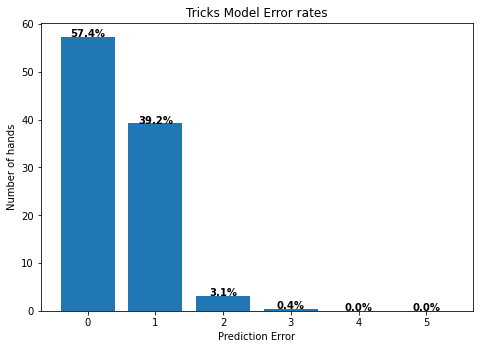

In [130]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds_rounded)

In [131]:
def print_pred_eval_kpis(y_true, y_pred):
    """
    Prints model evaluation kpis
    """
    
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
    from sklearn.metrics import r2_score, explained_variance_score
    from sklearn.metrics import precision_score, recall_score, f1_score
    from sklearn.metrics import roc_curve, roc_auc_score, log_loss

    # Assuming y_true contains actual target values and y_pred contains predicted values

    # Regression Metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explained_var = explained_variance_score(y_true, y_pred)

    # Print or display the calculated metrics
    print("Regression Metrics:")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"Median Absolute Error: {medae}")
    print(f"R-squared: {r2}")
    print(f"Explained Variance: {explained_var}")

In [132]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.46098725879949554
MAE: 0.5184933360994171
Median Absolute Error: 0.4041748046875
R-squared: 0.7057917095509282
Explained Variance: 0.7057990335013125


In [133]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds_rounded)

Regression Metrics:
MSE: 0.5504814247655807
MAE: 0.4648108913175725
Median Absolute Error: 0.0
R-squared: 0.6486753249406119
Explained Variance: 0.6488176946003577


In [134]:
valid_preds_linreg = reg.predict(valid_df)

In [135]:
valid_preds_linreg_rounded = [round(pred) for pred in valid_preds_linreg]

In [137]:
print_pred_eval_kpis(y_true=valid_targets_df, y_pred=valid_preds_linreg)

Regression Metrics:
MSE: 0.4527751502331973
MAE: 0.5155634642407526
Median Absolute Error: 0.4041748046875
R-squared: 0.7039696597477729
Explained Variance: 0.7039696680591688


In [138]:
print_pred_eval_kpis(y_true=valid_targets_df, y_pred=valid_preds_linreg_rounded)

Regression Metrics:
MSE: 0.5412296526262795
MAE: 0.4622314985735862
Median Absolute Error: 0.0
R-squared: 0.6461369442668567
Explained Variance: 0.6463268655498512


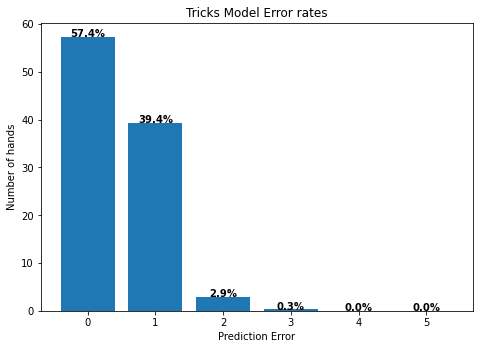

In [57]:
plot_trick_error_rates(targets_list = valid_targets_df, 
                       preds_list=valid_preds_linreg_rounded)

#### Test single hand manually

In [58]:
hand = {feature:[0] for feature in model_features}
single_hand_test_df = pd.DataFrame(hand)
single_hand_test_df

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,player_seat1,player_seat2,player_seat3,player_seat4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
single_hand_test_df['player_seat1'] = 0
single_hand_test_df['player_seat2'] = 1
single_hand_test_df['player_seat3'] = 0
single_hand_test_df['player_seat4'] = 0
single_hand_test_df['num_suits'] = 3
single_hand_test_df['has_right'] = 0
single_hand_test_df['has_left'] = 0
single_hand_test_df['has_Atrump'] = 0
single_hand_test_df['has_Ktrump'] = 1
single_hand_test_df['has_Qtrump'] = 1
single_hand_test_df['has_Ttrump'] = 1
single_hand_test_df['has_9trump'] = 0
single_hand_test_df['num_off_Q'] = 2
single_hand_test_df['num_off_K'] = 0
single_hand_test_df['num_off_A'] = 0

In [60]:
single_test_pred = reg.predict(single_hand_test_df)
single_test_pred

array([1.87719727])

### Regularized linear regression

#### Ridge

In [61]:
from sklearn.linear_model import Ridge

In [62]:
ridge = Ridge(alpha=0.8).fit(train_df, train_targets_df)

In [63]:
ridge.score(test_df, test_targets_df)

0.7057946831238937

In [64]:
# ridge.coef_
for coef in range(len(ridge.coef_)):
    print(f'{train_df.columns[coef]}: {ridge.coef_[coef]}')

has_right: 1.5887862079485149
has_left: 0.8557568454107107
has_Atrump: 0.7124274302871323
has_Ktrump: 0.7687041915138149
has_Qtrump: 0.7123446686134777
has_Ttrump: 0.6607680920308198
has_9trump: 0.5949755502601947
num_off_A: 0.5367612316101913
num_off_K: 0.3179489390691507
num_off_Q: 0.04082015539306586
num_suits: -0.27351084862035857
player_seat1: -0.0014406423761887794
player_seat2: -0.009639785985339808
player_seat3: 0.017931902520316133
player_seat4: -0.006851474733172855


In [65]:
test_preds = ridge.predict(test_df)
test_preds[0:5]

array([1.59235438, 0.83107108, 1.18622224, 2.73431886, 0.32260899])

In [66]:
test_preds_rounded = [round(pred) for pred in test_preds]
test_preds_rounded[0:5]

[2, 1, 1, 3, 0]

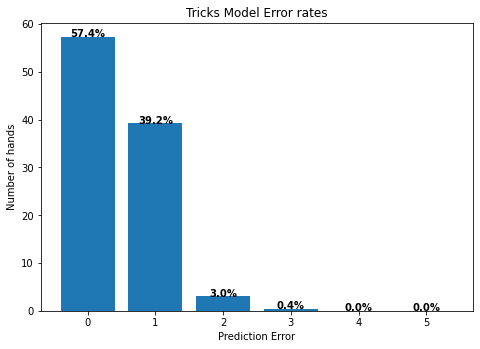

In [67]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds_rounded)

In [103]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.6264395544460993
MAE: 0.4754043338717459
Median Absolute Error: 0.0
R-squared: 0.6001978213818112
Explained Variance: 0.6413902566676277


#### Lasso

In [69]:
from sklearn.linear_model import Lasso

In [70]:
lasso = Lasso(alpha=0.01).fit(train_df, train_targets_df)

In [71]:
sum(lasso.coef_ != 0)

10

In [72]:
# lasso.coef_
for coef in range(len(lasso.coef_)):
    print(f'{train_df.columns[coef]}: {lasso.coef_[coef]}')

has_right: 1.5142131885176455
has_left: 0.7479962911244168
has_Atrump: 0.5576119099578054
has_Ktrump: 0.6952390141543738
has_Qtrump: 0.6388628522525545
has_Ttrump: 0.58679532058564
has_9trump: 0.521005248477673
num_off_A: 0.3919933359159256
num_off_K: 0.24729915336301492
num_off_Q: -0.0
num_suits: -0.2792331684620004
player_seat1: -0.0
player_seat2: -0.0
player_seat3: 0.0
player_seat4: -0.0


In [73]:
test_preds = lasso.predict(test_df)
test_preds[0:5]

array([1.45026109, 0.78085726, 1.06009043, 2.61540122, 0.38333685])

In [74]:
test_preds_rounded = [round(pred) for pred in test_preds]
test_preds_rounded[0:5]

[1, 1, 1, 3, 0]

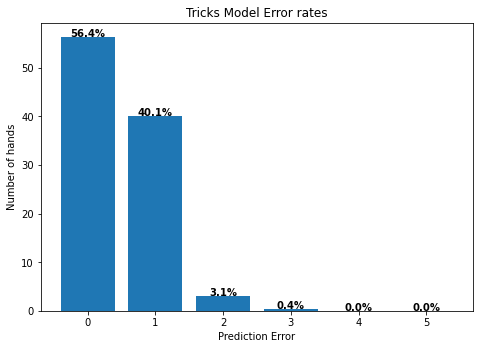

In [75]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds_rounded)

In [104]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.6264395544460993
MAE: 0.4754043338717459
Median Absolute Error: 0.0
R-squared: 0.6001978213818112
Explained Variance: 0.6413902566676277


In [ ]:
#### ElasticNet
# from sklearn.linear_model import ElasticNet
# elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.01).fit(train_df, train_targets_df)
# elastic_net.score(test_df, test_targets_df)

#### Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [157]:
classifier =  RandomForestClassifier(
    n_estimators=100, 
    max_features=0.9,
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion = 'entropy', 
    verbose=0
)

In [158]:
%%time

classifier.fit(train_df, train_targets_df)  # Fit the model

Wall time: 53 s


RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.9)

In [172]:
test_preds = classifier.predict(test_df)
# test_preds = classifier.predict_proba(test_df)
test_preds[0:3]

array([2, 1, 0], dtype=int64)

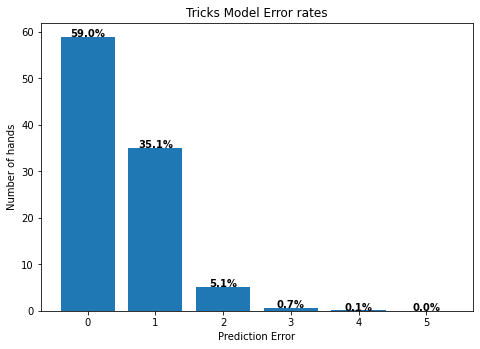

In [173]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds)

In [174]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.629670029997273
MAE: 0.47725031990098804
Median Absolute Error: 0.0
R-squared: 0.5981360882837568
Explained Variance: 0.6392741216799588


In [151]:
single_hand_preds = classifier.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.03488877, 0.41715252, 0.47046467, 0.05944157, 0.01691922,
        0.00113324]])

In [162]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

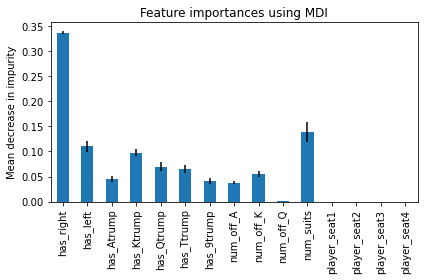

In [163]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### GBM

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

In [107]:
gbm_clf = GradientBoostingClassifier(learning_rate=0.1, 
                                     n_estimators=10, 
                                     #subsample=0.9, 
                                     #max_depth=6
                                    )

#### Fit the model

In [108]:
%%time

gbm_clf.fit(train_df, train_targets_df)

Wall time: 25.9 s


GradientBoostingClassifier(n_estimators=10)

In [109]:
# Create test preds
test_preds = gbm_clf.predict(test_df)
#test_preds = gbm_clf.predict_proba(test_df)
test_preds[0:3]

array([1, 0, 0], dtype=int64)

In [110]:
single_hand_preds = gbm_clf.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.19617988, 0.35565337, 0.29232209, 0.10672844, 0.04070897,
        0.00840725]])

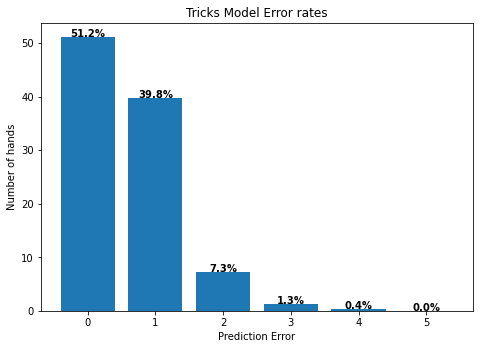

In [111]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds)

In [112]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.871787879423549
MAE: 0.5987497640074678
Median Absolute Error: 0.0
R-squared: 0.44361320894775114
Explained Variance: 0.5271900611715368


In [113]:
valid_preds = gbm_clf.predict(valid_df)
valid_preds_rounded = [round(pred) for pred in valid_preds]

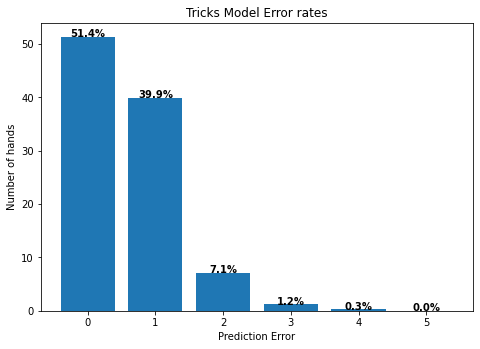

In [114]:
plot_trick_error_rates(targets_list = valid_targets_df, 
                       preds_list=valid_preds_rounded)

In [115]:
importances = gbm_clf.feature_importances_

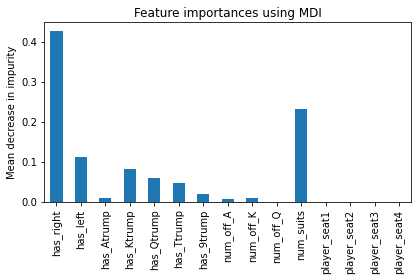

In [116]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Look at worst predictions

In [205]:
# add targets to test_df
test_df.loc[:,'actual'] = test_targets_df

C:\Users\jerem\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\jerem\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [206]:
# add preds to test_df
test_df.loc[:,'preds'] = test_preds

In [207]:
test_df.loc[:,'pred_err'] = abs(test_targets_df - test_preds)

In [209]:
test_df.sort_values('pred_err', ascending=False).head(10)

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,player_seat1,player_seat2,player_seat3,player_seat4,actual,preds,pred_err
184415,0,0,0,0,0,1,1,0,0,1,3,0,1,0,0,4,0,4
71255,0,0,0,0,1,1,0,0,2,1,3,0,1,0,0,5,1,4
277687,0,0,0,0,0,1,1,0,1,1,4,0,1,0,0,4,0,4
176791,0,0,0,0,1,0,1,1,1,0,3,0,0,1,0,5,1,4
113555,0,0,0,0,1,1,0,0,1,1,4,1,0,0,0,4,0,4
44567,0,0,0,0,0,1,1,0,1,0,3,1,0,0,0,4,0,4
58987,0,0,0,0,0,1,1,1,1,0,4,0,0,0,1,5,1,4
115207,0,0,1,0,1,0,0,0,2,1,3,0,0,0,1,5,1,4
50099,0,0,0,0,1,0,1,0,0,1,3,1,0,0,0,4,0,4
116515,0,0,0,1,1,0,0,0,2,0,4,0,1,0,0,5,1,4


### Cross Validation

In [139]:
from sklearn.model_selection import GridSearchCV

In [140]:
grid_params = {'n_estimators':[10], 'max_depth':[4,5], 'learning_rate':[0.1] ,'subsample':[0.9]}

In [141]:
clf = GridSearchCV(gbm_clf, grid_params)

In [142]:
%%time

clf.fit(train_df, train_targets_df)

Wall time: 5min 22s


GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=10),
             param_grid={'learning_rate': [0.1], 'max_depth': [4, 5],
                         'n_estimators': [10], 'subsample': [0.9]})

In [143]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [144]:
clf.cv_results_

{'mean_fit_time': array([24.12750382, 31.91451254]),
 'std_fit_time': array([0.34865573, 1.76299289]),
 'mean_score_time': array([0.15954123, 0.2064991 ]),
 'std_score_time': array([0.00291815, 0.02637562]),
 'param_learning_rate': masked_array(data=[0.1, 0.1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.9, 0.9],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1,
   'max_depth': 4,
   'n_estimators': 10,
   'subsample': 0.9},
  {'learning_rate': 0.1,
   'max_depth': 5,
   'n_estimators': 10,
   'subsample': 0.9}],
 'split0_test_score': array([0.55610494, 0.56972476]),

In [145]:
clf.best_estimator_

GradientBoostingClassifier(max_depth=5, n_estimators=10, subsample=0.9)

In [ ]:
clf.best_estimator_.predict_proba(single_hand_test_df)

In [ ]:
single_hand_preds = clf.predict_proba(single_hand_test_df)
single_hand_preds

In [ ]:
test_preds = clf.best_estimator_.predict(test_df)

In [ ]:
importances = clf.best_estimator_.feature_importances_

In [ ]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Save out model to disk using joblib

In [ ]:
import joblib

In [ ]:
pwd

In [ ]:
joblib.dump(classifier, 'C:/Users/jerem/Desktop/nonsense/euchre/models/trick_model_rf_v0.sav')

#### Plot probability output

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
ax.bar(num_tricks_taken, single_hand_preds.tolist()[0])

plt.xlabel("Tricks taken")
plt.ylabel("Percent of hands")
plt.title("Expected tricks taken")

# ax.bar_label(trick_preds, label_type='center')

plt.show()

In [ ]:
trick_preds = single_hand_preds.tolist()[0]
trick_preds

In [ ]:
plot_expected_tricks_taken(expected_tricks_taken = trick_preds)

#### Breakdown of percent of hands predicted correctly, 1 off, 2 off, etc.

In [164]:
results_dict = {str(num): 0 for num in range(0,6)}

#for idx, pred in enumerate(test_targets_df[0:100]):
for idx, pred in enumerate(test_targets_df):
    pred_diff = abs(pred - test_preds[idx])
    results_dict[str(pred_diff)] += 1

results_dict
# list(results_dict.values())

{'0': 28125, '1': 16737, '2': 2445, '3': 332, '4': 32, '5': 0}

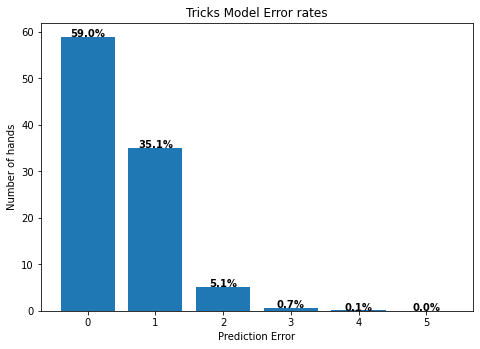

In [165]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
percents = [round(100.0*x / sum(results_dict.values()),1) for x in results_dict.values()]
graph = ax.bar(num_tricks_taken, percents)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x,y = p.get_xy()
    plt.text(x+width/2,
             y+height*1,
             str(percents[i])+'%',
             ha='center',
             weight='bold')
    i += 1

plt.xlabel("Prediction Error")
plt.ylabel("Number of hands")
plt.title("Tricks Model Error rates")

plt.show()

#### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_columns = ['player_seat']
categorical_encoder = OneHotEncoder()

In [ ]:
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
    ],
)

In [ ]:
rf = Pipeline(
    [
        ('preprocess', preprocessing),
        ('classifier', RandomForestClassifier(random_state=123))
    ]

)

In [ ]:
#rf.fit(train_df, train_targets_df)

In [ ]:
rf

In [ ]:
#single_hand_preds = rf.predict_proba(single_hand_test_df)
#single_hand_preds

## Next Steps

In [ ]:
# Build separate model for team tricks won

# Standardize input features to linear model
# Cross-validate tree-based models - RF, GBM, etc.
# sklearn pipeline

# PyTorch models
    # compare PyTorch version vs. sklearn
# Classification models to predict likelihood for each score outcome

# EUCHRE questions to answer:
# Is it possible to take a trick with an off-suit Jack, that wouldn't have been taken with the 10 or 9 ???

# Is there ever a time when knowing the current score of the game should affect which card to play?
    # If opponent has 9 points, play more aggressively?

# Is there ever a time when knowing the current number of tricks taken should affect which card to play?
    # If opponents have taken 2 tricks already, play more aggressively?   

### Write out all hand results to csv local

In [ ]:
pwd

In [ ]:
all_hand_results_df = pd.read_csv('all_hand_results.csv')

In [ ]:
all_hand_results_df.shape

In [ ]:
hand_results_40k_df = all_hand_results_df.head(40000)
hand_results_40k_df.shape

In [ ]:
hand_results_40k_df.to_csv('hand_results_40k.csv', index=False)